In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

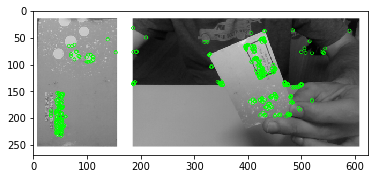

In [5]:
img = cv2.imread('image.png',0)

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(img, None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img, kp, img, color=(0,255,0), flags=0)
plt.imshow(img2)
plt.show()